# MNIST(필기체 숫자) 인식 - 오차역전파 

- 60,000개의 training data와 10,000개의 test data를 2차원 행렬 데이터 타입으로 가져옴

In [2]:
import numpy as np
training_data = np.loadtxt('./mnist_train.csv',delimiter=',',dtype=np.float32)
test_data = np.loadtxt('./mnist_test.csv',delimiter=',',dtype=np.float32)

print("training_data.shpae =", training_data.shape, ", test_data.shape = ", test_data.shape)

training_data.shpae = (60000, 785) , test_data.shape =  (10000, 785)


- 첫번째 열에는 정답이 있고, 나머지 784개의 수는 이미지의 정보
- 아래 코드는 이미지 나타내보기

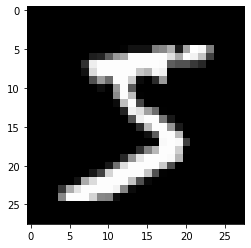

In [5]:
import matplotlib.pyplot as plt
img = training_data[0][1:].reshape(28,28)
plt.imshow(img,cmap='gray')
plt.show()

## external function

In [6]:
# 시그모이드 함수
def sigmoid(x):
    return 1/(1+np.exp(-x))

## NeuralNetwork class

In [24]:
from datetime import datetime # 학습경과시간 측정

class NeuralNetwork:
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):  # 가중치/ 바이어스/ 각 층 출력값/ 학습율 초기화
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        
        #은닉층 가중치 W2 = (784 x 100) 의 shape으로 초기화 xavier/he 방법으로 가중치 초기화 
        self.W2 = np.random.randn(self.input_nodes, self.hidden_nodes)/np.sqrt(self.input_nodes/2)
        self.b2 = np.random.rand(self.hidden_nodes)
        
        #출력층 가중치 W3 = (100 X 10)
        self.W3 = np.random.randn(self.hidden_nodes, self.output_nodes)/np.sqrt(self.hidden_nodes/2)
        self.b3 = np.random.rand(self.output_nodes)
        
        #선형회귀값(sigmoid에 들어가기전 값), 출력값 초기화
        self.Z3 = np.zeros([1,output_nodes])
        self.A3 = np.zeros([1,output_nodes])
        
        self.Z2 = np.zeros([1,hidden_nodes])
        self.A2 = np.zeros([1,hidden_nodes])
       
        self.Z1 = np.zeros([1,input_nodes])
        self.A1 = np.zeros([1,input_nodes])
        
        self.learning_rate = learning_rate
        
    def feed_forward(self): #feed forward 이용하여 손실함수 값 계산
        delta = 1e-7
        
        # 입력층 선형회귀 값, 출력값 계산
        self.Z1 = self.input_data
        self.A1 = self.input_data
        
        # 은닉층 선형회귀 값 Z2, 출력값 A2 계산
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = sigmoid(self.Z2)
        
        # 출력층 선형회귀 값 Z3, 출력값 A3 계산
        self.Z3 = np.dot(self.A2, self.W3) + self.b3
        self.A3 = sigmoid(self.Z3)
        
        #cross-entropy
        return -np.sum(self.target_data*np.log(self.A3 + delta) + (1-self.target_data)*np.log((1-self.A3)+delta))
    
        
    def loss_val(self): # 손실함수 값 계산 (외부 출력용)
        delta = 1e-7
        
        # 입력층 선형회귀 값, 출력값 계산
        self.Z1 = self.input_data
        self.A1 = self.input_data
        
        # 은닉층 선형회귀 값 Z2, 출력값 A2 계산
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = sigmoid(self.Z2)
        
        # 출력층 선형회귀 값 Z3, 출력값 A3 계산
        self.Z3 = np.dot(self.A2, self.W3) + self.b3
        self.A3 = sigmoid(self.Z3)
        
        #cross-entropy
        return -np.sum(self.target_data*np.log(self.A3 + delta) + (1-self.target_data)*np.log((1-self.A3)+delta))
    
    def train(self,input_data,target_data): # 오차역전파 공식을 이용하여 가중치/바이어스 업데이트
        self.target_data = target_data
        self.input_data = input_data
        
        #먼저 feed_forward를 통해서 최종 출력값과 이를 바탕으로 현재의 에러 값 계산
        loss_val = self.feed_forward()
        
        #출력층 loss인 loss_3 구하기
        loss_3 = (self.A3 - self.target_data)*self.A3*(1-self.A3)
        
        #출력층 가중치 W3, 출력층 바이어스 b3 업데이트
        self.W3 = self.W3 - self.learning_rate*np.dot(self.A2.T, loss_3)
        self.b3 = self.b3 - self.learning_rate*loss_3
        
        #은닉층 loss인 loss_2 구하기
        loss_2 = np.dot(loss_3,self.W3.T)*self.A2*(1-self.A2)
        
        #은닉층 가중치 W2, 은닉층 바이어스 b2 업데이트
        self.W2 = self.W2 - self.learning_rate*np.dot(self.A1.T, loss_2)
        self.b2 = self.b2 - self.learning_rate*loss_2
        
    def predict(self,input_data): #입력 데이터에 대해 미래 값 예측
        Z2 = np.dot(input_data,self.W2) + self.b2
        A2 = sigmoid(Z2)
        
        Z3 = np.dot(A2, self.W3) + self.b3
        A3 = sigmoid(Z3)
        
        # 가장 큰 값의 인덱스 반환
        predicted_num = np.argmax(A3)
        
        return predicted_num

    def accuracy(self, test_data): #신경망 기반의 딥러닝 아키텍쳐 정확도 측정
        matched_list =[]
        not_matched_list = []
        
        for index in range(len(test_data)):
            # 정답분리
            label = int(test_data[index,0])
            
            #normalize
            # 가끔 입력데이터 초과로 overflow가 발생하므로 최댓값으로 나눠주고 nomarlize 함
            data = (test_data[index,1:]/255.0*0.99)+0.01
            
            predicted_num = self.predict(np.array(data,ndmin=2))
            
            if label == predicted_num:
                matched_list.append(index)
            else:
                not_matched_list.append(index)
        print("Current Accuracy = ", 100*(len(matched_list)/len(test_data))," %")
        
        return matched_list, not_matched_list
    
    
    

## 검증

In [27]:
input_nodes = 784
hidden_nodes = 100
output_nodes = 10
learning_rate = 0.3
epochs = 5

nn = NeuralNetwork(input_nodes,hidden_nodes,output_nodes,learning_rate)

start_time = datetime.now()

for i in range(epochs):
    for step in range(len(training_data)):
        
        #input_data, target_data normalize
        #0과1사이의 값을 갖도록 정규화
        target_data = np.zeros(output_nodes) + 0.01
        target_data[int(training_data[step,0])] = 0.99
        
        input_data = ((training_data[step,1:]/255.0)*0.99)+0.01
        
        nn.train(np.array(input_data,ndmin=2),np.array(target_data,ndmin=2))
        
        if step%400 == 0:
            print("step = ",step, ", loss_val = ",nn.loss_val())
end_time = datetime.now()
print("\n time = ", end_time-start_time)

step =  0 , loss_val =  4.3369184141090855
step =  400 , loss_val =  1.4603062144530494
step =  800 , loss_val =  1.560838271891869
step =  1200 , loss_val =  0.714106282789858
step =  1600 , loss_val =  0.9036939347762223
step =  2000 , loss_val =  1.6484484656257203
step =  2400 , loss_val =  0.6927810735670289
step =  2800 , loss_val =  0.8785227461518478
step =  3200 , loss_val =  0.8147267925596378
step =  3600 , loss_val =  0.6920093692084823
step =  4000 , loss_val =  0.9311602711659213
step =  4400 , loss_val =  0.8184476581601098
step =  4800 , loss_val =  1.057122235006054
step =  5200 , loss_val =  0.7595369897952713
step =  5600 , loss_val =  1.4183994006333653
step =  6000 , loss_val =  0.8006572571069521
step =  6400 , loss_val =  0.8981539152378888
step =  6800 , loss_val =  0.8784074767665684
step =  7200 , loss_val =  0.81595370687027
step =  7600 , loss_val =  0.9238256512639631
step =  8000 , loss_val =  0.973562632184879
step =  8400 , loss_val =  0.7988274537351464

step =  10800 , loss_val =  1.1797364743271745
step =  11200 , loss_val =  1.0247690939008698
step =  11600 , loss_val =  3.493421994657481
step =  12000 , loss_val =  1.1678253652963282
step =  12400 , loss_val =  0.9851210687932064
step =  12800 , loss_val =  1.1450805941189315
step =  13200 , loss_val =  1.0436508317922606
step =  13600 , loss_val =  1.26076933841702
step =  14000 , loss_val =  1.0807443753970023
step =  14400 , loss_val =  1.1125544737701103
step =  14800 , loss_val =  1.1271230563515815
step =  15200 , loss_val =  1.2797832012515682
step =  15600 , loss_val =  1.1479869009318198
step =  16000 , loss_val =  1.2320695004101627
step =  16400 , loss_val =  1.166041646113447
step =  16800 , loss_val =  1.2551657199198936
step =  17200 , loss_val =  1.1707433740556406
step =  17600 , loss_val =  1.1089832496406689
step =  18000 , loss_val =  1.1539156461204865
step =  18400 , loss_val =  1.042241125704806
step =  18800 , loss_val =  1.0230330425018532
step =  19200 , lo

step =  21600 , loss_val =  1.2729892274931005
step =  22000 , loss_val =  1.203944085186898
step =  22400 , loss_val =  1.1574856478369917
step =  22800 , loss_val =  1.1922572838231469
step =  23200 , loss_val =  1.1113336129442168
step =  23600 , loss_val =  1.1730052111701734
step =  24000 , loss_val =  1.1750802651294867
step =  24400 , loss_val =  1.2911786562800553
step =  24800 , loss_val =  1.0228424129950568
step =  25200 , loss_val =  1.0987915055393538
step =  25600 , loss_val =  1.170982083096395
step =  26000 , loss_val =  1.165675925413755
step =  26400 , loss_val =  1.1956487657339077
step =  26800 , loss_val =  1.3994743803837275
step =  27200 , loss_val =  1.087677296461491
step =  27600 , loss_val =  1.33623813530305
step =  28000 , loss_val =  1.0521017174720089
step =  28400 , loss_val =  1.2688360071564313
step =  28800 , loss_val =  1.1278084234534662
step =  29200 , loss_val =  1.1837300557647343
step =  29600 , loss_val =  1.2164810753565016
step =  30000 , los

step =  32400 , loss_val =  1.1812181131528412
step =  32800 , loss_val =  1.2504075282251974
step =  33200 , loss_val =  1.2063031616257431
step =  33600 , loss_val =  1.126500366463678
step =  34000 , loss_val =  1.1801715625676883
step =  34400 , loss_val =  1.3017100347649544
step =  34800 , loss_val =  9.171391787218111
step =  35200 , loss_val =  1.2440911125862435
step =  35600 , loss_val =  1.093190813450391
step =  36000 , loss_val =  1.1120950707178885
step =  36400 , loss_val =  1.2449123303489462
step =  36800 , loss_val =  1.2201861242809515
step =  37200 , loss_val =  1.1508103505055365
step =  37600 , loss_val =  1.1967307450973093
step =  38000 , loss_val =  1.218758138769329
step =  38400 , loss_val =  1.3437792959793295
step =  38800 , loss_val =  1.236122621318076
step =  39200 , loss_val =  1.322627296810972
step =  39600 , loss_val =  1.0961760842683872
step =  40000 , loss_val =  1.212392129020158
step =  40400 , loss_val =  1.3854145288337116
step =  40800 , loss

step =  42800 , loss_val =  1.3021082530384782
step =  43200 , loss_val =  1.2695476919399742
step =  43600 , loss_val =  1.2708124188768974
step =  44000 , loss_val =  1.3247597917705036
step =  44400 , loss_val =  1.4199258422963161
step =  44800 , loss_val =  1.206750008975301
step =  45200 , loss_val =  1.4006865254357295
step =  45600 , loss_val =  1.2799913155524452
step =  46000 , loss_val =  1.2533007240683705
step =  46400 , loss_val =  1.197003973186058
step =  46800 , loss_val =  1.1815909432950147
step =  47200 , loss_val =  1.2020813102792098
step =  47600 , loss_val =  6.60367057242831
step =  48000 , loss_val =  1.2719836180304585
step =  48400 , loss_val =  1.3499424151285897
step =  48800 , loss_val =  1.2428807088140035
step =  49200 , loss_val =  1.2021074418128344
step =  49600 , loss_val =  1.1175354656192373
step =  50000 , loss_val =  1.3416068435773187
step =  50400 , loss_val =  1.1178293017587482
step =  50800 , loss_val =  1.4006102026535714
step =  51200 , l

In [28]:
nn.accuracy(test_data)

Current Accuracy =  96.71  %


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  158,
  15